<a href="https://colab.research.google.com/github/CodeWithMayank-Py/ML-Models/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
# see the tensorflow version
tf.__version__

'2.13.0'

In [ ]:
# Download data
train, valid, test = tfds.load('cats_vs_dogs', split=['train[:60%]','train[60%:90%]','train[90%:]'],as_supervised=True,
                               batch_size=32,shuffle_files=True)
print('Element in training data: ',train.element_spec)
print('Element in valid data: ',valid.element_spec)
print('Element in test data: ',test.element_spec)
print('Image count:',train.cardinality()*32)
print('Image count:',valid.cardinality()*32)
print('Image count:',test.cardinality()*32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMGKN20/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Element in training data:  (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Element in valid data:  (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Element in test data:  (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Image count: tf.Tensor(13984, shape=(), dtype=int64)
Image count: tf.Tensor(7008, shape=(), dtype=int64)
Image count: tf.Tensor(2336, shape=(), dtype=int64)


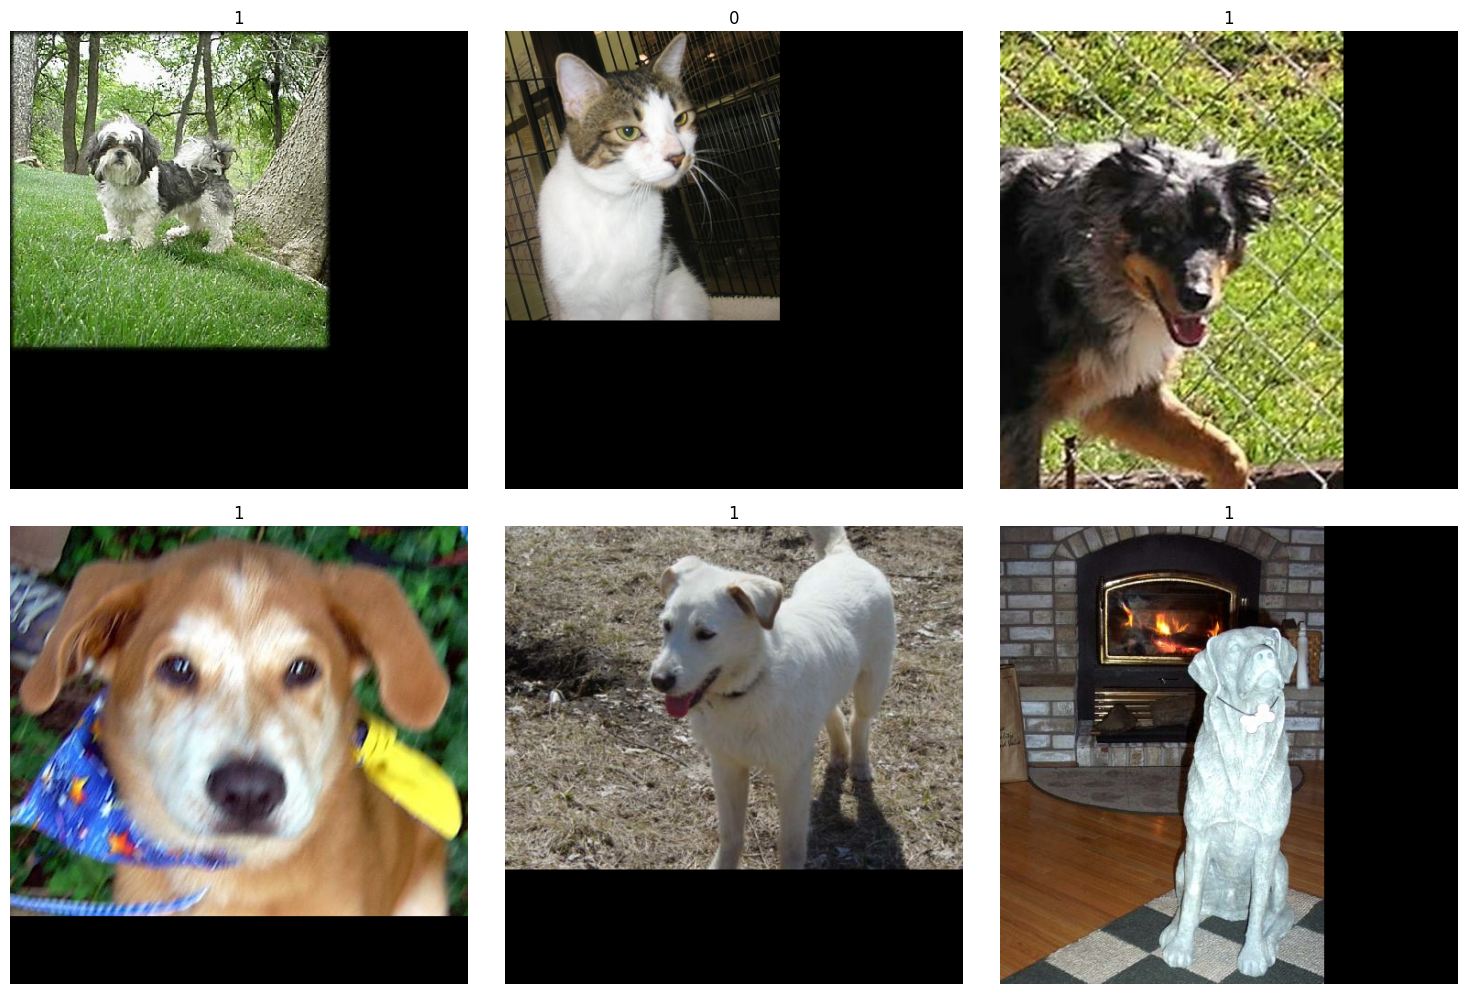

In [ ]:
# make plot data
for images, labels in train.take(1):break
images_to_plot : int=6
plt.figure(figsize=(15,15))
for index in range(images_to_plot):
  plt.subplot(3,3,index+1)
  plt.imshow(images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(labels[index].numpy())
plt.tight_layout()
plt.show()

In [ ]:
print("Maximum pixel values: ", tf.reduce_max(images))
print("Minimum pixel values: ", tf.reduce_min(images))
print("Shape of inputs (X): ", images.shape)
print("Object type of inputs (X): ", type(images))
print("Data Type in inputs (X): ", images.dtype)
print("Object type of outputs (y): ", type(labels))
print("Data type in outputs (X): ", labels.dtype)

Maximum pixel values:  tf.Tensor(255, shape=(), dtype=uint8)
Minimum pixel values:  tf.Tensor(0, shape=(), dtype=uint8)
Shape of inputs (X):  (32, 500, 500, 3)
Object type of inputs (X):  <class 'tensorflow.python.framework.ops.EagerTensor'>
Data Type in inputs (X):  <dtype: 'uint8'>
Object type of outputs (y):  <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X):  <dtype: 'int64'>


In [ ]:
resizing_layer = tf.keras.layers.Resizing(height=299, width=299, interpolation="bilinear") # Using Xception model size 299x299
train=train.map(lambda images,labels: (resizing_layer(images),labels))
valid=valid.map(lambda images,labels: (resizing_layer(images),labels))
test=test.map(lambda images,labels: (resizing_layer(images),labels))

In [ ]:
# Make apply data augmentation

random_flip = tf.keras.layers.RandomFlip('horizontal_and_vertical', name='random_flip')
random_zoom = tf.keras.layers.RandomZoom(height_factor = 0.1, width_factor=0.1, name='random_zoom')
random_rotate = tf.keras.layers.RandomRotation(0.3, name='random_rotate')
random_brightness = tf.keras.layers.RandomBrightness(0.3, value_range=(0.0, 255.0), name='random_brightness')
augmentations = [random_flip, random_zoom, random_rotate, random_brightness]

# make apply augmentation on training data
for augmentation in augmentations:
  train = train.map(lambda images, labels: (augmentation(images), labels))

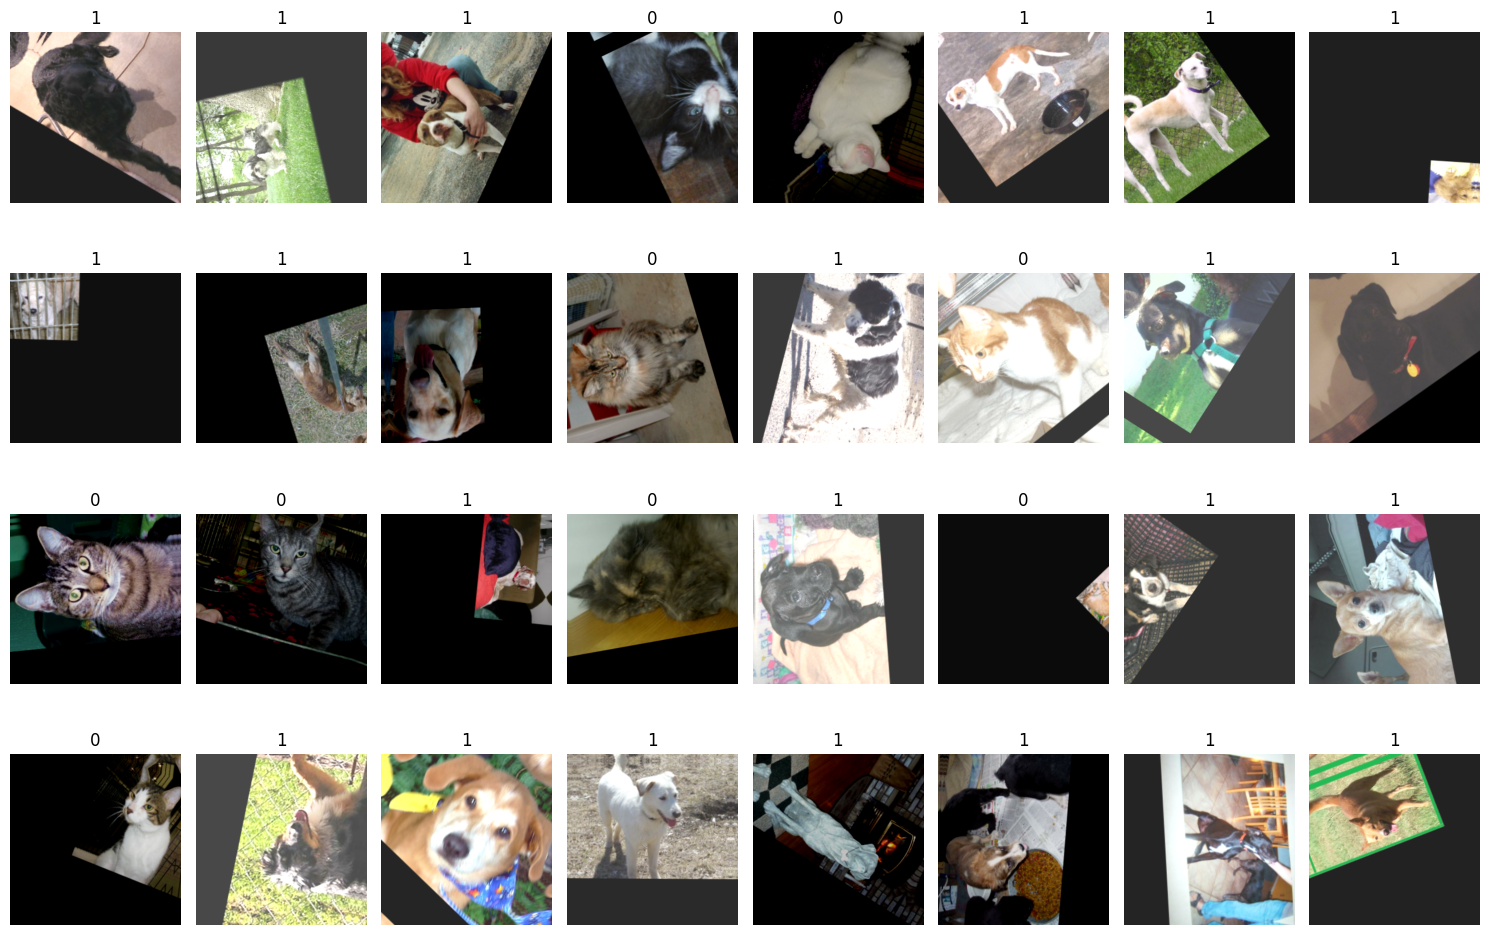

In [ ]:
# make plot data
for images, labels in train.take(1):break
images_to_plot : int=8*4
plt.figure(figsize=(15,10))
for index in range(images_to_plot):
  plt.subplot(4,8,index+1)
  plt.imshow(images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(labels[index].numpy())
plt.tight_layout()
plt.show()

In [ ]:
print("Maximum pixel values: ", tf.reduce_max(images))
print("Minimum pixel values: ", tf.reduce_min(images))
print("Shape of inputs (X): ", images.shape)
print("Object type of inputs (X): ", type(images))
print("Data Type in inputs (X): ", images.dtype)
print("Object type of outputs (y): ", type(labels))
print("Data type in outputs (X): ", labels.dtype)

Maximum pixel values:  tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values:  tf.Tensor(0.0, shape=(), dtype=float32)
Shape of inputs (X):  (32, 299, 299, 3)
Object type of inputs (X):  <class 'tensorflow.python.framework.ops.EagerTensor'>
Data Type in inputs (X):  <dtype: 'float32'>
Object type of outputs (y):  <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X):  <dtype: 'int64'>


In [ ]:
# Cardinality => Gives total no of images
# set class name
class_names=['cats','dogs']

In [ ]:
# make build Xception preprocessing layer
class XceptionPreProcessing(tf.keras.layers.Layer):

  # define layer call method
  def call(self, inputs)->tf.Tensor:
    return tf.keras.applications.xception.preprocess_input(inputs)

In [ ]:
xception_base = tf.keras.applications.Xception()
xception_base.summary()

91884032/91884032 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
xception_base = tf.keras.applications.Xception(include_top=False)
xception_base.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
xception_base.trainable=False
xception_base.summary(line_length=120, expand_nested=True, show_trainable=True)

Model: "xception"
___________________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        Trainable  
 input_2 (InputLayer)               [(None, None, None, 3)]             0           []                                  N          
                                                                                                                                   
 block1_conv1 (Conv2D)              (None, None, None, 32)              864         ['input_2[0][0]']                   N          
                                                                                                                                   
 block1_conv1_bn (BatchNormalizati  (None, None, None, 32)              128         ['block1_conv1[0][0]']              N          
 on)                                                      

In [ ]:
# Building model as Sequential model

model=tf.keras.Sequential(layers=None, name='custom_xception_classifier')
model.add(XceptionPreProcessing(input_shape=(299,299,3), name='preprocessing_00'))

model.add(xception_base)

model.add(tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool_02'))
# Dense Layer
#model.add(tf.keras.layers.Dense(1024))   -> Only in VGG16 model
#model.add(tf.keras.layers.Dropout(0.3))  -> Only in VGG16 layer
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [ ]:
model.summary()

Model: "custom_xception_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing_00 (Xception  (None, 299, 299, 3)       0         
 PreProcessing)                                                  
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pool_02 (Gl  (None, 2048)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20865578 (79.60 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20861480 (79.58 

In [ ]:
# Model Learning
history=model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1,
                                                mode='auto', restore_best_weights=True)

# make train model
history = model.fit(train, batch_size=128, epochs=10_000, verbose=2, callbacks=[early_stop],
                    validation_split=0, validation_data=valid, shuffle=True)

Epoch 1/10000
437/437 - 501s - loss: 0.4029 - sparse_categorical_accuracy: 0.8489 - val_loss: 0.1478 - val_sparse_categorical_accuracy: 0.9824 - 501s/epoch - 1s/step
Epoch 2/10000
437/437 - 447s - loss: 0.2435 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.0925 - val_sparse_categorical_accuracy: 0.9834 - 447s/epoch - 1s/step
Epoch 3/10000
437/437 - 446s - loss: 0.2131 - sparse_categorical_accuracy: 0.9131 - val_loss: 0.0753 - val_sparse_categorical_accuracy: 0.9850 - 446s/epoch - 1s/step
Epoch 4/10000
437/437 - 437s - loss: 0.1988 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9850 - 437s/epoch - 1000ms/step
Epoch 5/10000
437/437 - 468s - loss: 0.1887 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.0611 - val_sparse_categorical_accuracy: 0.9854 - 468s/epoch - 1s/step
Epoch 6/10000
437/437 - 444s - loss: 0.1844 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.0571 - val_sparse_categorical_accuracy: 0.9852 - 444s/epoch - 1s/step


KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(history.history).head()

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(marker='.')
plt.grid().plt.title('Training Accuracy'), plt.xlabel('epochs'), plt.ylabel('accuracy')
plt.show()

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(marker='.')
plt.grid(), plt.title('Training Losses'), plt.xlabel('epochs'), plt.ylabel('loss')
plt.show()